This notebook aims to walkthrough a working example of the changes implemented during GSoC 2016. I'll try to explain as much details as I can. MNE should be installed by cloning from master for the below code to work.
MNE is a software that deals with M/EEG data and provides interface to analyze data at processing steps.

To get started, we have to first load the sample dataset which comes with MNE package. Quoting from the documentation
> > The sample data set is recorded using a 306-channel Neuromag vectorview system.
In this experiment, checkerboard patterns were presented to the subject into the left and right visual field, interspersed by tones to the left or right ear. The interval between the stimuli was 750 ms. Occasionally a smiley face was presented at the center of the visual field. The subject was asked to press a key with the right index finger as soon as possible after the appearance of the face.

In [34]:
# import necessary modules
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import mne
from mne.datasets import sample
from mne.preprocessing import XdawnTransformer, Xdawn
from mne.decoding import Vectorizer, UnsupervisedSpatialFilter

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import cross_val_score
from sklearn.decomposition import PCA, FastICA

# fetch the data set folder
data_path = sample.data_path()

In MNE continuous data is stored in objects called `Raw`. The underlying data is an array of shape (samples, channels). We will use a `.fif` file to load our continuous data. Refer [this](http://martinos.org/mne/stable/manual/io.html#ch-convert) cheatsheet for other file format that are supported. We will now load a `.fif` file from the directory whose path we just fetched.

In [2]:
# construct the basic Raw object with continuos data
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.fiff.Raw(raw_fname, preload=True)

Notice that we have set `preload` parameter to be true. This loads the `raw` object into the memory for fast operations. Setting it to `False` would be advisable if your pc memory is not sufficient.
However we wont be working with `raw` object as they are continous which generally means analyzing is difficult. We therefore have to make it discretized. To do that we make use of `Epochs` data type. This divides the continuous data into trials of some duration and data array becomes a 3D matrix of shape(samples, n_channels, n_times).
We will now define the parameters required to construct an `epochs` object.

In [3]:
# Initialize the parameters required for epochs object

events = mne.find_events(raw)
tmin, tmax = -0.1, 0.3
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

* `events` is an array of shape(n_events, 3). First column contains the event time and third column contains the  `event id` Second column is interesting only if we provide a string in `find_events` `output` parameter. Check [here](http://martinos.org/mne/stable/generated/mne.find_events.html) for more information.

* `event_id` parameters is a dictionary, with keys as names for the event id(which could later used in epochs object for referencing) and values as the event id integer. If none all events are considered otherwise only the id defined in dict.

* `tmin` and `tmax` parameter defines the time(in seconds) to consider before and after the event has occured.

* `picks` is an array with indices of channels to include in epochs.

Finally we create the `epochs` object using `Epochs` class.

In [4]:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False, picks=picks,
                    baseline=None, preload=True, add_eeg_ref=False, verbose=False)

From this point, changes made during GSoC will be discussed and presented.
We will first begin with the `XdawnTransformer` which is a refactored class of `Xdawn`. `Xdawn` algorithm applies spatial filters to improve signal to signal + noise ratio (SSNR) of the ERP responses. Spatial filtering means to extract components with certain specific spatial characteristics of the signal. ERP(evoked response potential) is the response in nervous system of animals after some stimuli is introduced. In other words `Xdawn` algorithm filters the signal so that artifacts(unwanted response from other sources such as hearbeat, eye blink) are minimized. Xdawn trains a set of spatial filters which could be applied to any set of data to transform them. It could be used as supervised classification for evoked response. We will see how good they are at predicting the events below.

In [5]:
Xdt = XdawnTransformer()
Xdt_filtered_data = Xdt.fit_transform(epochs.get_data())

`epochs.get_data()` returns an array of shape(samples, n_channels, n_times). `Xdt.fit_transform` method first computes the filter value to apply and then transforms the data according to the computed filters. `XdawnTransformer` works with numpy arrays which makes them fast, compared to earlier `Xdawn`. This also enables us to pipeline a chain of transformers(filters) using scikit-learn `pipeline` class. We will now construct a pipeline, for which we will use `Vectorizer` class for compability and `LogisticRegression` to estimate or classify the evoked response. We will then perform a `score` operation to evaluate our algorithm.

In [26]:
clf_Xdt = make_pipeline(XdawnTransformer(), Vectorizer(), MinMaxScaler(), LogisticRegression(penalty='l1'))
y = epochs.events[:, -1]
X = epochs.get_data()
score_Xdt = cross_val_score(clf_Xdt, X, y, cv=5)
print(score_Xdt.mean())

0.826363029139


`clf` is a `pipeline` with transformers at each step and an estimator at the end step. `clf` executes `fit_transform` sequentially.
* `Vectorizer` class converts the 3D output of `XdawnTransformer` to 2D, as `scikit-learn` API enforces 2D data.
* `MinMaxScaler` is used to stadardize the data. The features are scaled in some range. If some feature has high magnitude, it will dominate the data set and classification will become faulty.
* `LogisticRegression` is the estimator we use for classification. Read more [here](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression).
* `y` is the event_id for each sample.
Finally we print the mean of scores obtained per cv.
Next lets compare the time taken, between `Xdawn` and `XdawnTransformer`

In [7]:
start = time.time()
Xd = Xdawn()
Xd.fit_transform(epochs, y)
Xd_time = time.time() - start
print "Time for Xdawn", Xd_time

start = time.time()
Xdt = XdawnTransformer()
Xdt.fit_transform(X, y)
Xdt_time = time.time() - start
print "Time for XdawnTransformer", Xdt_time

print "Time decrease of {0}%".format((Xd_time - Xdt_time) / Xd_time * 100)

Time for Xdawn 0.122698068619
Time for XdawnTransformer 0.0590150356293
Time decrease of 51.9022293557%


It is a significant improvement over the original version. This is due to its lightweight nature achieved by using numpy arrays and not an heavy object like `epochs`. This version however does not support correction of event overlapping. See [here](https://github.com/mne-tools/mne-python/blob/master/mne/preprocessing/xdawn.py#L375) for more information.
Scores however are not so interesting. Lets plot the data for better visulization.
We will use `Evoked` data structure which stores the average of epochs samples. This class contains nice functions for plotting the data. An easy way to get `Evoked` from epochs is to use `epochs.average()`. However as we are working with numpy arrays that is no longer possible. We will create `EvokedArray`(stores average of all trials) object by defining it here. Before plotting we will see how many channels were filtered.

epochs channels : 59 
filtered channels : 2


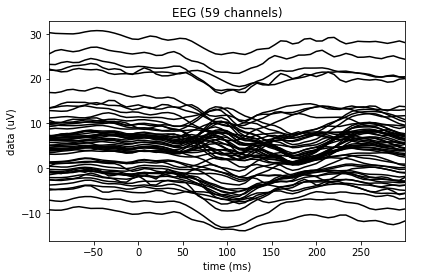

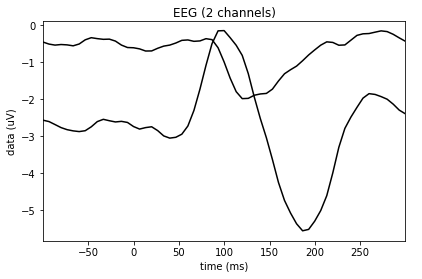

In [29]:
print("epochs channels : {0} \nfiltered channels : {1}").format(len(epochs._data[1]), len(Xdt_filtered_data[1]))

# Now plot the channels of epochs and filtered data
ev = epochs.average()
ev.plot(show=False, window_title='Raw epochs')

Xdt_mean_data = np.mean(Xdt_filtered_data, axis=0)
ev_Xdt = mne.EvokedArray(Xdt_mean_data, mne.create_info(len(Xdt_mean_data), epochs.info['sfreq'],
                                                        ch_types='eeg'), tmin=tmin)
ev_Xdt.plot(show=False, window_title='Xdawn')
plt.show()

We plotted the filtered data channels and the raw epochs channels. Its clear that filtered data would be much easier to analyze compared to unfiltered one.
Next we move on to `UnsupervisedSpatialFilter` class which uses a scikit-learn decomposition algorithm to find the spatial filters and apply them on epochs. Mainly we use [ICA](https://en.wikipedia.org/wiki/Independent_component_analysis)(independent component analysis) and [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)(principle component analysis).However as these are unsupervised they cannot be trained and hence they are `transformed` directly. Here we will compare the filtered data using plots as we did above. This has been already compared [here](https://github.com/mne-tools/mne-python/blob/master/examples/decoding/plot_decoding_unsupervised_spatial_filter.py), however we will discuss about the mentioned class while comparing.

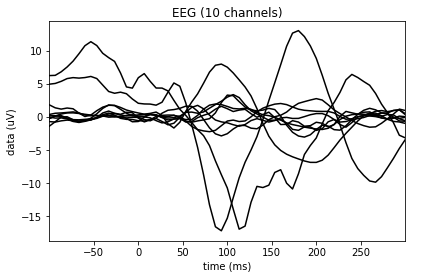

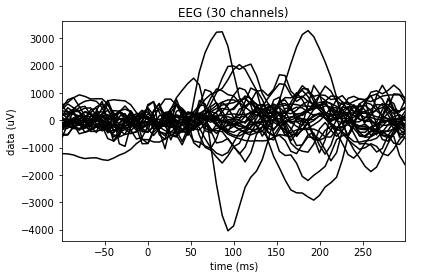

In [33]:
pca = UnsupervisedSpatialFilter(PCA(10), average=False)
pca_data = pca.fit_transform(X)

# pca_data is the array of decomposed data i.e filtered matrix based on PCA algorithm.
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(10, epochs.info['sfreq'],
                                     ch_types='eeg'), tmin=tmin)

ev.plot(show=False, window_title="PCA")
ica = UnsupervisedSpatialFilter(FastICA(30), average=False)
ica_data = ica.fit_transform(X)
# ica_data is the array of decomposed data based on ICA algorithm
ev1 = mne.EvokedArray(np.mean(ica_data, axis=0),
                      mne.create_info(30, epochs.info['sfreq'],
                                      ch_types='eeg'), tmin=tmin)
ev1.plot(show=False, window_title='ICA')

plt.show()

The first graph plots the Principal compenents. PCA finds the 10 most 'different' signals. The 10 components have the highest variance from the mean of the data. PCA squashes the data with maximum variance into lowered dimensions.
However in analysis of brain signals we would want to know each possible physiological component. ICA splits channels into as many independent components as possible. Therefore ICA proves to be more useful compared to PCA in brain signal analysis.
`UnsupervisedSpatialFilter` takes a decomposition algorithm in its constructor and `transform` method transforms epochs data. `fit` is not used and is defined for compability purpose(for using in pipelines).
These has been the significant work during my GSoC. Many goals were not met and I feel I could have done better. None the less it was a wonderful opportunity to learn and talk to many knowledaglbe people. I would continue to contribute and learn in future with MNE.